In [28]:
from tokenizers import Tokenizer
from transformers import PreTrainedTokenizerFast
from tokenizers.models import WordLevel, BPE
from tokenizers.pre_tokenizers import Whitespace,Split,ByteLevel, WhitespaceSplit
from tokenizers.normalizers import Lowercase, NFKC
import os
import polars as pl
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing
import numpy as np
np.float = np.float64
from tqdm import tqdm
import time
import json
from tokenizers.trainers import BpeTrainer, UnigramTrainer, WordLevelTrainer, WordPieceTrainer
import gc
from transformers import AutoConfig, AutoTokenizer, AutoModel, DataCollatorWithPadding
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
# from rdkit.Chem.AllChem import Descriptors
from mordred import Calculator as MordredCalculator
from mordred import descriptors as mordred_descriptors
import math
import mapply


multiprocessing.cpu_count()

80

In [2]:
train_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_v2.csv').select(
        pl.col('molecule'),
#         pl.col('bb1', 'bb2', 'bb3').cast(pl.UInt16),
        # pl.col('BRD4', 'HSA', 'sEH').cast(pl.UInt8),
    ).collect()
print(train_df.estimated_size('gb'), 'GB')
train_df

6.842148938216269 GB


molecule
str
"""C#CCOc1ccc(CNc…"
"""C#CCOc1ccc(CNc…"
"""C#CCOc1ccc(CNc…"
"""C#CCOc1ccc(CNc…"
"""C#CCOc1ccc(CNc…"
…
"""[N-]=[N+]=NCCC…"
"""[N-]=[N+]=NCCC…"
"""[N-]=[N+]=NCCC…"


In [3]:
test_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/test_v4.csv').select(
        pl.col('molecule'),
#         pl.col('bb1', 'bb2', 'bb3').cast(pl.UInt16),
        # pl.col('BRD4', 'HSA', 'sEH').cast(pl.UInt8),
    ).collect()
print(test_df.estimated_size('gb'), 'GB')
test_df

0.06128192972391844 GB


molecule
str
"""C#CCCC[C@H](Nc…"
"""C#CCCC[C@H](Nc…"
"""C#CCCC[C@H](Nc…"
"""C#CCCC[C@H](Nc…"
"""C#CCCC[C@H](Nc…"
…
"""Cn1ncc2cc(Nc3n…"
"""[N-]=[N+]=NCCC…"
"""COC(=O)c1ccnc(…"


In [4]:
mols = [Chem.MolFromSmiles(m) for m in train_df[:2000, 'molecule']]
len(mols)

2000

# RDKit

In [41]:
%%time
desc = [Descriptors.CalcMolDescriptors(mol) for mol in tqdm(mols)]
len(desc)

100%|██████████████████████████████████████| 2000/2000 [01:01<00:00, 32.70it/s]

CPU times: user 1min, sys: 815 ms, total: 1min 1s
Wall time: 1min 1s


2000

In [42]:
df = pd.DataFrame(desc)
df

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.022584,12.022584,0.147985,-0.351126,0.183859,14.829268,702.124,670.876,703.192320,215,...,0,0,0,2,0,0,0,0,0,0
1,11.915654,11.915654,0.156881,-0.355972,0.156604,10.945946,710.925,686.733,711.049734,193,...,0,0,0,2,0,0,0,0,0,0
2,11.962513,11.962513,0.159820,-0.366334,0.179210,10.675000,685.089,656.865,686.154538,207,...,0,0,0,3,0,0,0,0,0,0
3,11.876213,11.876213,0.144780,-0.380871,0.109711,10.729730,652.060,622.828,653.165437,197,...,0,0,0,2,0,0,0,0,1,0
4,11.954303,11.954303,0.054611,-0.403060,0.142767,10.666667,638.033,610.817,639.149787,191,...,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,12.124913,12.124913,0.011785,-0.738838,0.177726,10.916667,636.961,616.801,638.093000,187,...,0,0,0,2,0,0,0,0,0,0
1996,12.186547,12.186547,0.114778,-0.453687,0.178338,10.972973,666.068,642.884,667.090557,193,...,0,0,0,2,0,1,0,0,0,0
1997,12.025424,12.025424,0.121975,-0.381089,0.211473,14.100000,687.105,656.865,688.170188,209,...,0,0,0,2,0,0,0,0,0,0
1998,11.908274,11.908274,0.145911,-0.386643,0.240413,10.885714,618.002,594.818,619.123572,181,...,0,0,0,2,0,0,0,0,0,0


In [43]:
df.describe()

/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/conda/lib/python3.10/site-pac

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.0,2000.000000,2000.000000,2000.000000
mean,12.250045,12.250045,0.112969,-0.690562,0.193141,12.230506,666.163143,640.762047,667.123135,196.322000,...,0.020500,0.013500,0.01450,2.005000,0.008000,0.063500,0.0,0.044000,0.081500,0.007500
std,0.672500,0.672500,0.047958,0.896608,0.046193,2.433604,44.716458,42.600571,44.604497,16.674752,...,0.145225,0.115431,0.11957,0.070551,0.089107,0.243921,0.0,0.205146,0.408584,0.086299
min,11.749155,11.749155,0.000004,-5.771388,0.062567,10.483871,552.927000,532.767000,554.097023,157.000000,...,0.000000,0.000000,0.00000,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,11.905668,11.905668,0.081435,-0.511890,0.157991,10.944444,635.976000,610.821000,637.089685,185.000000,...,0.000000,0.000000,0.00000,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,11.962488,11.962488,0.133797,-0.391184,0.192093,11.088235,664.012500,636.837000,665.062229,195.000000,...,0.000000,0.000000,0.00000,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,12.145731,12.145731,0.151054,-0.362456,0.222101,12.820513,693.460000,668.880000,694.217138,207.000000,...,0.000000,0.000000,0.00000,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,15.403464,15.403464,0.163701,-0.300436,0.347519,36.128205,816.095000,784.697000,816.160991,253.000000,...,2.000000,1.000000,1.00000,3.000000,1.000000,1.000000,0.0,1.000000,4.000000,1.000000


In [52]:
RDKIT_DESCRIPTORS = list(df.columns)
len(RDKIT_DESCRIPTORS)
RDKIT_DESCRIPTORS

['MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',


In [76]:
np.finfo(np.float16).min, np.finfo(np.float16).max

(-65500.0, 65500.0)

In [48]:
for i, col in enumerate(df.columns):
    dtype = type(desc[0][col])
    if dtype == int:
        print(df[col].min(), df[col].max())

157 253
0 0
30 49
4 7
8 15
0 5
0 3
0 5
1 3
1 3
2 5
7 13
4 6
9 16
9 17
0 5
0 3
0 5
2 7
0 0
0 1
0 1
0 0
0 0
3 7
0 2
0 2
0 0
0 0
1 5
1 5
0 0
0 1
0 0
3 8
4 6
0 1
0 2
0 1
0 1
0 2
0 1
0 1
0 1
0 6
0 2
1 5
0 0
3 6
0 3
0 0
0 0
0 0
1 3
0 0
0 5
0 0
0 0
0 0
0 2
0 4
0 1
0 0
0 6
0 0
0 1
0 2
0 2
0 0
0 0
0 1
0 1
0 0
0 1
0 3
0 1
0 2
0 1
0 1
0 1
0 0
0 1
0 0
0 2
0 1
0 1
0 0
0 0
0 1
0 3
0 1
0 0
0 2
0 0
0 2
0 1
0 1
2 3
0 1
0 1
0 0
0 1
0 4
0 1


In [26]:
[type(v) for k, v in desc[0].items()]

[numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 float,
 float,
 float,
 float,
 float,
 int,
 int,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 numpy.float64,
 float,
 numpy.float64,
 float,
 float,
 numpy.float64,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 numpy.float64,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float

In [22]:
from collections import Counter
counter = Counter()
counter.update([type(v) for k, v in desc[0].items()])
counter

Counter({int: 104, float: 77, numpy.float64: 29})

In [20]:
100_000_000 / 1000 * 29 / 3600 / 24 / 

33.56481481481482

In [85]:
def calc_rdkit_descriptors(m):
    desc = Descriptors.CalcMolDescriptors(Chem.MolFromSmiles(m))
    desc = [desc[col] for col in RDKIT_DESCRIPTORS]
#     out_of_range_idxs = np.where(desc > np.finfo(np.float16).max)
#     print(out_of_range_idxs, desc[out_of_range_idxs])

    # idx=42, name=Ipc
    # to prevent np.float16 Out Of Range casting
    
    desc[42] = math.log(desc[42])
    desc = np.array(desc, dtype = np.float16)
    return desc

In [148]:
test_descriptors = np.load('/home/dangnh36/datasets/competitions/leash_belka/processed/features/rdkit210/test.npy')
test_descriptors.shape, test_descriptors.dtype

((878022, 210), dtype('float16'))

In [149]:
np.mean(np.isnan(test_descriptors), axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [150]:
keep_col_idxs = np.where(np.mean(np.isnan(test_descriptors), axis=0) == 0)
keep_col_idxs

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [151]:
remove_col_idxs = np.where(np.mean(np.isnan(test_descriptors), axis=0) > 0)[0].tolist()
remove_col_idxs

[]

In [152]:
def analyze_constant_features(features):
    assert features.ndim==2
    n_rows, n_cols = features.shape
    ignore_cols = []
    for i in range(n_cols):
        values, counts = np.unique(features[:, i], return_counts=True)
        if len(values) > 3:
            print(f'{i}: count={len(values)}')
        else:
            value2count = {v:c for v, c in zip(values, counts)}
            print(f'{i}: count={len(values)} {value2count}')

        if len(values) == 1:
            ignore_cols.append(i)
    print('IGNORE COLS:\n', ignore_cols)
    return ignore_cols

In [153]:
constant_cols = analyze_constant_features(test_descriptors)

0: count=586
1: count=586
2: count=12219
3: count=8829
4: count=4974
5: count=2080
6: count=1651
7: count=1477
8: count=1363
9: count=121
10: count=1 {0.0: 878022}
11: count=429
12: count=282
13: count=306
14: count=677
15: count=744
16: count=885
17: count=866
18: count=53
19: count=121
20: count=340
21: count=241
22: count=301
23: count=253
24: count=233
25: count=1317
26: count=767
27: count=1525
28: count=2278
29: count=1289
30: count=1491
31: count=1528
32: count=1533
33: count=1447
34: count=1499
35: count=1797
36: count=1851
37: count=2065
38: count=2014
39: count=2583
40: count=2531
41: count=1074
42: count=1540
43: count=1463
44: count=1878
45: count=2467
46: count=1435
47: count=814
48: count=1876
49: count=1033
50: count=595
51: count=158
52: count=284
53: count=564
54: count=721
55: count=637
56: count=177
57: count=2143
58: count=2669
59: count=2489
60: count=2677
61: count=971
62: count=2126
63: count=7
64: count=758
65: count=216
66: count=2371
67: count=1713
68: count=2

In [109]:
constant_cols

[10,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 69,
 82,
 125,
 157,
 158,
 160,
 162,
 163,
 164,
 168,
 170,
 174,
 175,
 178,
 186,
 192,
 193,
 197,
 199,
 206]

In [159]:
keep_col_idxs = sorted(list(set(list(range(len(RDKIT_DESCRIPTORS)))).difference(set(remove_col_idxs)).difference(set(constant_cols))))
print(len(keep_col_idxs))
keep_col_idxs

189


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 159,
 161,
 165,
 166,
 167,
 169,
 171,
 172,
 173,
 176,
 177,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 187,
 188,
 189,
 190,
 191,
 194,
 195,
 196,
 198,
 200,
 201,
 202,
 203,
 20

In [160]:
keep_col_names = [RDKIT_DESCRIPTORS[idx] for idx in keep_col_idxs]
keep_col_names

['MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA9'

In [162]:
test_descriptors_df = pd.DataFrame()
test_descriptors_df[RDKIT_DESCRIPTORS] = test_descriptors.astype(np.float32)
test_descriptors_df

/tmp/ipykernel_57853/3769434538.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_descriptors_df[RDKIT_DESCRIPTORS] = test_descriptors.astype(np.float32)
/tmp/ipykernel_57853/3769434538.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_descriptors_df[RDKIT_DESCRIPTORS] = test_descriptors.astype(np.float32)
/tmp/ipykernel_57853/3769434538.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

/tmp/ipykernel_57853/3769434538.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_descriptors_df[RDKIT_DESCRIPTORS] = test_descriptors.astype(np.float32)
/tmp/ipykernel_57853/3769434538.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_descriptors_df[RDKIT_DESCRIPTORS] = test_descriptors.astype(np.float32)
/tmp/ipykernel_57853/3769434538.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

/tmp/ipykernel_57853/3769434538.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_descriptors_df[RDKIT_DESCRIPTORS] = test_descriptors.astype(np.float32)
/tmp/ipykernel_57853/3769434538.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_descriptors_df[RDKIT_DESCRIPTORS] = test_descriptors.astype(np.float32)
/tmp/ipykernel_57853/3769434538.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

/tmp/ipykernel_57853/3769434538.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_descriptors_df[RDKIT_DESCRIPTORS] = test_descriptors.astype(np.float32)
/tmp/ipykernel_57853/3769434538.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_descriptors_df[RDKIT_DESCRIPTORS] = test_descriptors.astype(np.float32)
/tmp/ipykernel_57853/3769434538.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

/tmp/ipykernel_57853/3769434538.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_descriptors_df[RDKIT_DESCRIPTORS] = test_descriptors.astype(np.float32)
/tmp/ipykernel_57853/3769434538.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_descriptors_df[RDKIT_DESCRIPTORS] = test_descriptors.astype(np.float32)
/tmp/ipykernel_57853/3769434538.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.437500,12.437500,0.174561,-0.545898,0.220093,10.968750,467.50,438.25,467.25,178.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,12.570312,12.570312,0.159302,-0.615723,0.124634,12.250000,541.50,510.25,541.50,206.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,12.476562,12.476562,0.182007,-0.874023,0.223389,19.078125,491.75,454.25,491.25,192.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,12.476562,12.476562,0.116333,-0.629395,0.145020,11.078125,540.00,514.00,539.00,192.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,12.476562,12.476562,0.136963,-0.499756,0.223755,17.921875,507.75,470.50,507.25,192.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878017,12.421875,12.421875,0.175293,-0.647949,0.104065,11.484375,494.50,472.25,494.25,180.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
878018,12.375000,12.375000,0.203125,-0.584473,0.156250,21.781250,472.50,444.25,472.25,176.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
878019,13.859375,13.859375,0.013435,-0.787109,0.065552,11.273438,550.50,527.50,550.00,206.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
878020,13.867188,13.867188,0.129395,-0.680664,0.095215,17.578125,555.50,521.50,555.50,214.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [163]:
test_descriptors_df['MaxAbsEStateIndex'].to_numpy().mean()

13.370317

In [164]:
tmp = test_descriptors_df.describe()
tmp

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,878022.000000,878022.000000,878022.000000,878022.000000,878022.000000,878022.000000,878022.000000,878022.000000,878022.000000,878022.000000,...,878022.000000,878022.000000,878022.000000,878022.000000,878022.000000,878022.000000,878022.0,878022.000000,878022.000000,878022.000000
mean,13.370317,13.370317,0.073601,-1.441626,0.344972,16.500551,557.281433,526.919006,556.758911,206.062805,...,0.034714,0.048724,0.023858,0.013511,0.013389,0.085252,0.0,0.115292,0.100700,0.014341
std,0.781084,0.781084,0.061870,1.571657,0.189167,4.153749,74.325539,73.268852,74.095177,23.736860,...,0.190770,0.218625,0.153634,0.116246,0.115340,0.293998,0.0,0.330527,0.413419,0.119362
min,11.203125,11.203125,0.000000,-6.015625,0.012566,9.656250,273.250000,254.125000,273.250000,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,12.804688,12.804688,0.022842,-2.355469,0.183105,13.632812,507.500000,478.250000,507.250000,190.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,13.320312,13.320312,0.056732,-0.678711,0.315186,16.015625,552.500000,522.000000,552.000000,206.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,13.789062,13.789062,0.111084,-0.406494,0.473145,18.843750,602.500000,570.500000,601.500000,220.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,15.875000,15.875000,0.429199,0.156616,0.942383,58.593750,1213.000000,1166.000000,1211.000000,356.000000,...,4.000000,2.000000,2.000000,2.000000,2.000000,3.000000,0.0,3.000000,7.000000,2.000000


In [165]:
test_descriptors_df['Ipc']

0         18.015625
1         20.671875
2         18.203125
3         18.906250
4         18.515625
            ...    
878017    18.531250
878018    17.625000
878019    20.687500
878020    20.796875
878021    19.031250
Name: Ipc, Length: 878022, dtype: float32

In [166]:
tmp.loc['min', 'Ipc']

10.515625

In [167]:
keep_df = pl.DataFrame({
    'feature_idx': range(0, len(RDKIT_DESCRIPTORS)),
    'feature_name': RDKIT_DESCRIPTORS,
    'keep': [name in keep_col_names for name in RDKIT_DESCRIPTORS],
    **{
        agg: [tmp.loc[agg, col] for col in RDKIT_DESCRIPTORS]
        for agg in tmp.index if agg != 'count'
    }
})
keep_df

feature_idx,feature_name,keep,mean,std,min,25%,50%,75%,max
i64,str,bool,f64,f64,f64,f64,f64,f64,f64
0,"""MaxAbsEStateIn…",true,13.370317,0.781084,11.203125,12.804688,13.320312,13.789062,15.875
1,"""MaxEStateIndex…",true,13.370317,0.781084,11.203125,12.804688,13.320312,13.789062,15.875
2,"""MinAbsEStateIn…",true,0.073601,0.06187,0.0,0.022842,0.056732,0.111084,0.429199
3,"""MinEStateIndex…",true,-1.441626,1.571657,-6.015625,-2.355469,-0.678711,-0.406494,0.156616
4,"""qed""",true,0.344972,0.189167,0.012566,0.183105,0.315186,0.473145,0.942383
…,…,…,…,…,…,…,…,…,…
205,"""fr_thiazole""",true,0.085252,0.293998,0.0,0.0,0.0,0.0,3.0
206,"""fr_thiocyan""",false,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207,"""fr_thiophene""",true,0.115292,0.330527,0.0,0.0,0.0,0.0,3.0


In [168]:
keep_df['keep'].value_counts()

keep,count
bool,u32
true,189
false,21


In [169]:
keep_df.write_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/features/rdkit210/test_stats.csv')

In [172]:
len(keep_col_idxs)

189

In [175]:
print(sorted(list(set(range(210)).difference(set(keep_col_idxs)))))

[10, 69, 82, 125, 157, 158, 160, 162, 163, 164, 168, 170, 174, 175, 178, 186, 192, 193, 197, 199, 206]


In [120]:
def merge_chunks(chunk_npy_paths, save_path = None):
    ret = [np.load(fp) for fp in chunk_npy_paths]
    print([(e.shape, e.dtype) for e in ret])
    ret = np.concatenate(ret, axis = 0)
    print('MERGED:', ret.shape, ret.dtype)
    if save_path is not None:
        np.save(save_path, ret)
    return ret

In [192]:
# train_rdkit210 = merge_chunks([
#     '/home/dangnh36/datasets/competitions/leash_belka/processed/features/rdkit210/train_3_0_0_32805203.npy',
#     '/home/dangnh36/datasets/competitions/leash_belka/processed/features/rdkit210/train_3_1_32805204_65610407.npy',
#     '/home/dangnh36/datasets/competitions/leash_belka/processed/features/rdkit210/train_3_2_65610408_98415609.npy',
# ],
#     '/home/dangnh36/datasets/competitions/leash_belka/processed/features/rdkit210/train.npy'
# )

[((32805204, 210), dtype('float16')), ((32805204, 210), dtype('float16')), ((32805202, 210), dtype('float16'))]
MERGED: (98415610, 210) float16


# Mordred

In [14]:
MORDRED_DESCRIPTORS = [str(e) for e in MordredCalculator(mordred_descriptor, ignore_3D=False).descriptors]
MORDRED_DESCRIPTORS_2D = [str(e) for e in MordredCalculator(mordred_descriptor, ignore_3D=True).descriptors]
MORDRED_DESCRIPTORS_3D = list(set(MORDRED_DESCRIPTORS).difference(set(MORDRED_DESCRIPTORS_2D)))

print(len(MORDRED_DESCRIPTORS_3D))
MORDRED_DESCRIPTORS_3D

213


['Mor23v',
 'PNSA5',
 'Mor24se',
 'Mor13se',
 'Mor15',
 'GeomRadius',
 'PNSA2',
 'Mor21v',
 'Mor13v',
 'Mor06v',
 'Mor10se',
 'Mor29v',
 'GRAVp',
 'GRAVHp',
 'Mor03se',
 'Mor20',
 'Mor25se',
 'Mor04m',
 'Mor04p',
 'Mor24m',
 'Mor21p',
 'Mor25p',
 'Mor17m',
 'Mor04v',
 'Mor30p',
 'Mor20se',
 'Mor24p',
 'Mor03',
 'PNSA3',
 'Mor19',
 'FPSA2',
 'Mor27v',
 'Mor02p',
 'PBF',
 'RPCS',
 'Mor18',
 'Mor26v',
 'WPSA2',
 'Mor32',
 'Mor02v',
 'Mor12',
 'Mor02m',
 'Mor32m',
 'Mor02',
 'GRAV',
 'Mor04',
 'PPSA5',
 'Mor08se',
 'Mor12se',
 'Mor08p',
 'Mor24',
 'Mor14p',
 'Mor10v',
 'Mor15v',
 'Mor30',
 'FPSA5',
 'PPSA2',
 'TPSA',
 'FNSA5',
 'Mor21',
 'Mor05p',
 'Mor32se',
 'Mor08',
 'Mor17',
 'MOMI-Y',
 'Mor18m',
 'Mor16',
 'Mor18v',
 'FPSA3',
 'Mor01',
 'Mor07se',
 'MOMI-Z',
 'DPSA4',
 'Mor15se',
 'GeomShapeIndex',
 'Mor26se',
 'Mor05se',
 'Mor09p',
 'Mor25',
 'FNSA2',
 'Mor20m',
 'Mor25m',
 'WNSA5',
 'Mor26m',
 'Mor03v',
 'Mor11m',
 'TASA',
 'Mor09m',
 'WPSA1',
 'Mor16p',
 'Mor29p',
 'Mor20p',
 'Mor1

In [15]:
5_000_000 / 1000 * 2 / 60 / 24 / 3

2.3148148148148144

In [16]:
# %%time
# mordred_df = calc.pandas(mols)
# mordred_df

In [39]:
def replace_dy(smiles, return_mol=False):
    #Convert your SMILES to a mol object.
    mol = Chem.MolFromSmiles(smiles)

    #Create a mol object to replace the Dy atom with.
    new_attachment = Chem.MolFromSmiles('C')

    #Get the pattern for the Dy atom
    dy_pattern = Chem.MolFromSmiles('[Dy]')

    #This returns a tuple of all possible replacements, but we know there will only be one.
    new_mol = AllChem.ReplaceSubstructs(mol, dy_pattern, new_attachment)[0]

    #Good idea to clean it up
    Chem.SanitizeMol(new_mol)

    # #Since you want 3D mols later, I'd suggest adding hydrogens. Note: this takes up a lot more memory for the obj.
    # Chem.AddHs(new_mol)
    if return_mol:
        return new_mol
    else:
        return Chem.MolToSmiles(new_mol)

In [18]:
def batch_calc_mordred_descriptors(smiles_list):
    calc = MordredCalculator(mordred_descriptor, ignore_3D=False)
    mols = [replace_dy(smiles, return_mol = True) for smiles in smiles_list]
    ret = calc.pandas(mols)
    return ret

In [19]:
(1.5 + 0.75) * 60 / 2.25 * 1000

60000.0

In [20]:
selection_smiles = train_df.sample(30_000)['molecule'].to_list() + test_df.sample(20_000)['molecule'].to_list()
len(selection_smiles)

50000

In [21]:
%%time

tmp_df = batch_calc_mordred_descriptors(selection_smiles)

100%|██████████████████████████████████| 50000/50000 [1:43:30<00:00,  8.05it/s]


CPU times: user 8min 37s, sys: 1min 40s, total: 10min 17s
Wall time: 1h 44min 54s


In [22]:
tmp_df

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,28.519630,21.753040,0,0,46.916730,2.434901,4.842533,46.916730,1.303242,4.523767,...,10.493799,88.495470,509.130632,9.606238,4200,56,194.0,229.0,10.944444,7.805556
1,35.302968,24.258445,0,0,60.239322,2.397066,4.770407,60.239322,1.338652,4.737347,...,10.618176,96.145076,624.237956,8.106986,8331,69,236.0,275.0,11.694444,10.027778
2,32.285874,24.388781,0,0,53.277518,2.393598,4.760136,53.277518,1.268512,4.646568,...,10.428541,92.447757,657.121440,9.255232,6598,60,212.0,241.0,13.944444,9.388889
3,25.622253,20.023589,0,0,42.666804,2.400997,4.800608,42.666804,1.292933,4.419825,...,10.287150,82.444371,446.192720,8.112595,3316,49,170.0,197.0,9.861111,7.361111
4,35.965404,27.792790,0,0,58.617602,2.514363,4.951894,58.617602,1.274296,4.767658,...,10.841364,103.728176,677.128040,9.673258,7690,75,246.0,290.0,16.069444,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,36.843151,27.683549,0,0,60.694287,2.473271,4.866197,60.694287,1.319441,4.779889,...,10.797839,101.987899,662.214824,8.489934,8301,74,254.0,305.0,12.888889,9.916667
49996,30.660221,21.952813,0,2,51.200155,2.488634,4.886800,51.200155,1.312824,4.596924,...,10.593555,90.121182,526.305624,6.835138,5735,63,208.0,245.0,11.784722,8.541667
49997,30.545147,23.439374,0,0,49.829429,2.530090,4.989314,49.829429,1.311301,4.601779,...,10.880817,91.863850,510.263091,7.086987,4836,67,216.0,266.0,11.868056,8.097222
49998,29.606033,23.249440,0,0,47.812599,2.389934,4.746308,47.812599,1.258226,4.555766,...,10.352427,89.870224,535.211407,7.988230,5035,51,196.0,222.0,12.423611,8.263889


In [23]:
# !mkdir /home/dangnh36/datasets/competitions/leash_belka/processed/features/mordred

In [24]:
tmp_df.to_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/features/mordred/tmp_full_50k.csv', index = False)

In [25]:
tmp_df.to_numpy().astype(np.float16)

/tmp/ipykernel_9075/2187638750.py:1: RuntimeWarning: overflow encountered in cast
  tmp_df.to_numpy().astype(np.float16)


array([[ 28.52 ,  21.75 ,   0.   , ..., 229.   ,  10.945,   7.805],
       [ 35.3  ,  24.27 ,   0.   , ..., 275.   ,  11.695,  10.03 ],
       [ 32.28 ,  24.39 ,   0.   , ..., 241.   ,  13.945,   9.39 ],
       ...,
       [ 30.55 ,  23.44 ,   0.   , ..., 266.   ,  11.87 ,   8.09 ],
       [ 29.61 ,  23.25 ,   0.   , ..., 222.   ,  12.42 ,   8.266],
       [ 31.56 ,  24.44 ,   0.   , ..., 257.   ,  12.83 ,   8.64 ]],
      dtype=float16)

In [12]:
tmp_df = pd.read_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/features/mordred/tmp_full_50k.csv')
tmp_df

/tmp/ipykernel_61157/4055224447.py:1: DtypeWarning: Columns (1101,1118,1180,1197,1584) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/features/mordred/tmp_full_50k.csv')


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,28.519630,21.753040,0,0,46.916730,2.434901,4.842533,46.916730,1.303242,4.523767,...,10.493799,88.495470,509.130632,9.606238,4200,56,194.0,229.0,10.944444,7.805556
1,35.302968,24.258445,0,0,60.239322,2.397066,4.770407,60.239322,1.338652,4.737347,...,10.618176,96.145076,624.237956,8.106986,8331,69,236.0,275.0,11.694444,10.027778
2,32.285874,24.388781,0,0,53.277518,2.393598,4.760136,53.277518,1.268512,4.646568,...,10.428541,92.447757,657.121440,9.255232,6598,60,212.0,241.0,13.944444,9.388889
3,25.622253,20.023589,0,0,42.666804,2.400997,4.800608,42.666804,1.292933,4.419825,...,10.287150,82.444371,446.192720,8.112595,3316,49,170.0,197.0,9.861111,7.361111
4,35.965404,27.792790,0,0,58.617602,2.514363,4.951894,58.617602,1.274296,4.767658,...,10.841364,103.728176,677.128040,9.673258,7690,75,246.0,290.0,16.069444,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,36.843151,27.683549,0,0,60.694287,2.473271,4.866197,60.694287,1.319441,4.779889,...,10.797839,101.987899,662.214824,8.489934,8301,74,254.0,305.0,12.888889,9.916667
49996,30.660221,21.952813,0,2,51.200155,2.488634,4.886800,51.200155,1.312824,4.596924,...,10.593555,90.121182,526.305624,6.835138,5735,63,208.0,245.0,11.784722,8.541667
49997,30.545147,23.439374,0,0,49.829429,2.530090,4.989314,49.829429,1.311301,4.601779,...,10.880817,91.863850,510.263091,7.086987,4836,67,216.0,266.0,11.868056,8.097222
49998,29.606033,23.249440,0,0,47.812599,2.389934,4.746308,47.812599,1.258226,4.555766,...,10.352427,89.870224,535.211407,7.988230,5035,51,196.0,222.0,12.423611,8.263889


In [13]:
ignore_cols = []
overflow_cols = []
for col in tmp_df.columns:
    if tmp_df[col].dtype == object:
        print(col, tmp_df[col].dtype)
        ignore_cols.append(col)
        continue
    if tmp_df[col].isna().any():
        print('HAS NAN:', col)
    if tmp_df[col].max() > np.finfo(np.float16).max or tmp_df[col].min() < np.finfo(np.float16).min:
        overflow_cols.append(col)
        print('OVERFLOW:', col)

print(len(ignore_cols))
print(ignore_cols)

OVERFLOW: VR1_A
OVERFLOW: VR2_A
OVERFLOW: ATS0m
OVERFLOW: ATS4m
OVERFLOW: ATS7i
PNSA1 object
PNSA2 object
PNSA3 object
PNSA4 object
PNSA5 object
PPSA1 object
PPSA2 object
PPSA3 object
PPSA4 object
PPSA5 object
DPSA1 object
DPSA2 object
DPSA3 object
DPSA4 object
DPSA5 object
FNSA1 object
FNSA2 object
FNSA3 object
FNSA4 object
FNSA5 object
FPSA1 object
FPSA2 object
FPSA3 object
FPSA4 object
FPSA5 object
WNSA1 object
WNSA2 object
WNSA3 object
WNSA4 object
WNSA5 object
WPSA1 object
WPSA2 object
WPSA3 object
WPSA4 object
WPSA5 object
RNCS object
RPCS object
TASA object
TPSA object
RASA object
RPSA object
MAXsLi object
MAXssBe object
MAXssssBe object
MAXssBH object
MAXsssB object
MAXssssB object
MAXdCH2 object
MAXssCH2 object
MAXtCH object
MAXdsCH object
MAXaaCH object
MAXsssCH object
MAXddC object
MAXtsC object
MAXaaaC object
MAXssssC object
MAXsNH3 object
MAXsNH2 object
MAXssNH2 object
MAXdNH object
MAXaaNH object
MAXtN object
MAXsssNH object
MAXdsN object
MAXaaN object
MAXsssN object
MAXd

In [14]:
overflow_cols

['VR1_A', 'VR2_A', 'ATS0m', 'ATS4m', 'ATS7i']

All 3D descriptors is of type object (failure)

In [40]:
set(MORDRED_DESCRIPTORS_3D).difference(set(ignore_cols))

set()

In [42]:
final_ignore_cols = [e for e in MORDRED_DESCRIPTORS_3D] # deep copy
len(final_ignore_cols)

213

In [43]:
to_consider_cols = []
for col in set(ignore_cols).difference(final_ignore_cols):
    n_unique = tmp_df[col].apply(str).nunique()
    if n_unique <= 2:
        print(col, '-->', n_unique, tmp_df.loc[10, col])
        final_ignore_cols.append(col)
    else:
        to_consider_cols.append(col)

MAXssGeH2 --> 1 max() arg is an empty sequence (MAXssGeH2)
MAXssssB --> 1 max() arg is an empty sequence (MAXssssB)
MINsssAs --> 1 min() arg is an empty sequence (MINsssAs)
MINssssPb --> 1 min() arg is an empty sequence (MINssssPb)
MAXssSnH2 --> 1 max() arg is an empty sequence (MAXssSnH2)
MAXddC --> 1 max() arg is an empty sequence (MAXddC)
MINddssSe --> 1 min() arg is an empty sequence (MINddssSe)
MINsAsH2 --> 1 min() arg is an empty sequence (MINsAsH2)
MAXsssSnH --> 1 max() arg is an empty sequence (MAXsssSnH)
MAXsssSiH --> 1 max() arg is an empty sequence (MAXsssSiH)
MAXdSe --> 1 max() arg is an empty sequence (MAXdSe)
MINdSe --> 1 min() arg is an empty sequence (MINdSe)
MAXssSiH2 --> 1 max() arg is an empty sequence (MAXssSiH2)
MINsssPbH --> 1 min() arg is an empty sequence (MINsssPbH)
MINsssdAs --> 1 min() arg is an empty sequence (MINsssdAs)
MINssBe --> 1 min() arg is an empty sequence (MINssBe)
MAXsSiH3 --> 1 max() arg is an empty sequence (MAXsSiH3)
MINssGeH2 --> 1 min() arg i

In [52]:
print(len(to_consider_cols))
print(to_consider_cols)

81
['MAXssssSi', 'MDEO-22', 'MDEN-12', 'MINdCH2', 'MDEC-44', 'MINssCH2', 'MAXdCH2', 'MINssssC', 'MINaaNH', 'MAXdS', 'MAXaaaC', 'MAXaasN', 'MINddssS', 'MAXaaS', 'MINaaS', 'MDEC-11', 'MINdsCH', 'MINtN', 'MAXsSH', 'MDEC-34', 'MAXaaCH', 'MDEN-22', 'MAXsssCH', 'MINsF', 'MAXsssB', 'MDEN-23', 'MINaaCH', 'MAXssssC', 'MAXdssS', 'MAXddssS', 'MDEN-33', 'MINaasN', 'MAXsOH', 'MAXssS', 'MAXaaO', 'MINsssCH', 'MINtsC', 'MDEO-12', 'MDEC-14', 'MINdsN', 'MINaaO', 'MINssS', 'MINsSH', 'MAXtCH', 'MAXaaN', 'MDEN-11', 'MINdssS', 'MAXdNH', 'MINsssN', 'MINddsN', 'MINtCH', 'MINsNH2', 'MAXtsC', 'Vabc', 'MAXdsCH', 'MAXaaNH', 'MAXsBr', 'MAXtN', 'MDEO-11', 'MAXssCH2', 'MINaaN', 'MINaaaC', 'MDEN-13', 'MINsI', 'MINsBr', 'MINsOH', 'MINssssSi', 'MAXsF', 'MAXsI', 'MINsssB', 'MAXddsN', 'MINssO', 'MAXsssN', 'MAXsCl', 'MDEC-24', 'MAXsNH2', 'MINdNH', 'MAXssO', 'MAXdsN', 'MINdS', 'MINsCl']


In [53]:
print([e for e in to_consider_cols if 'min' not in e.lower() and 'max' not in e.lower()])

['MDEO-22', 'MDEN-12', 'MDEC-44', 'MDEC-11', 'MDEC-34', 'MDEN-22', 'MDEN-23', 'MDEN-33', 'MDEO-12', 'MDEC-14', 'MDEN-11', 'Vabc', 'MDEO-11', 'MDEN-13', 'MDEC-24']


In [63]:
len(to_consider_cols)

81

MAXssssSi 0.99844
MDEO-22 0.76932
MDEN-12 0.88396
MINdCH2 0.9683
MDEC-44 0.9349
MINssCH2 0.0543
MAXdCH2 0.9683
MINssssC 0.65462
MINaaNH 0.82444
MAXdS 0.99858
MAXaaaC 0.75236
MAXaasN 0.75758
MINddssS 0.93
MAXaaS 0.77372
MINaaS 0.77372
MDEC-11 0.2346
MINdsCH 0.9037
MINtN 0.9106
MAXsSH 0.99798
MDEC-34 0.65462
MAXaaCH 0.01294
MDEN-22 0.02542
MAXsssCH 0.28598
MINsF 0.5965
MAXsssB 0.9981
MDEN-23 0.3736
MINaaCH 0.01294
MAXssssC 0.65462
MAXdssS 0.98592
MAXddssS 0.93
MDEN-33 0.73854
MINaasN 0.75758
MAXsOH 0.87576
MAXssS 0.95382
MAXaaO 0.88458
MINsssCH 0.28598
MINtsC 0.8865
MDEO-12 0.3835
MDEC-14 0.65462
MINdsN 0.9877
MINaaO 0.88458
MINssS 0.95382
MINsSH 0.99798
MAXtCH 0.97834
MAXaaN 0.03652
MDEN-11 0.9922
MINdssS 0.98592
MAXdNH 0.99794
MINsssN 0.53764
MINddsN 0.92094
MINtCH 0.97834
MINsNH2 0.9743
MAXtsC 0.8865
Vabc 0.025
MAXdsCH 0.9037
MAXaaNH 0.82444
MAXsBr 0.86042
MAXtN 0.9106
MDEO-11 0.3016
MAXssCH2 0.0543
MINaaN 0.03652
MINaaaC 0.75236
MDEN-13 0.93824
MINsI 0.975
MINsBr 0.86042
MINsOH 0.875

<Axes: >

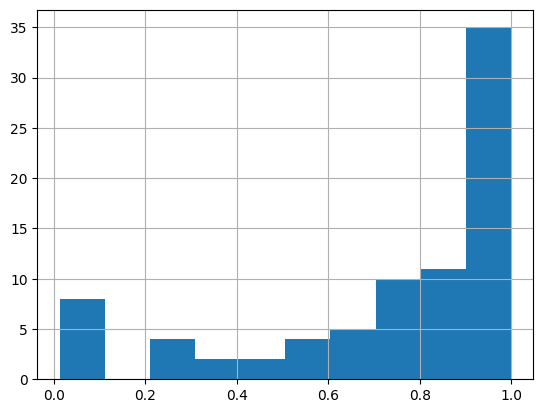

In [59]:
def to_float(s):
    try:
        return float(s)
    except:
        return np.nan

nan_pcts = []
for col in to_consider_cols:
    nan_pct = tmp_df[col].apply(to_float).isna().mean()
    print(col, nan_pct)
    nan_pcts.append(nan_pct)
    
pd.Series(nan_pcts).hist()

In [61]:
tmp_df['MDEC-44']

0        float division by zero (MDEC-44)
1        float division by zero (MDEC-44)
2        float division by zero (MDEC-44)
3        float division by zero (MDEC-44)
4                                     0.1
                       ...               
49995    float division by zero (MDEC-44)
49996    float division by zero (MDEC-44)
49997    float division by zero (MDEC-44)
49998    float division by zero (MDEC-44)
49999                             0.30327
Name: MDEC-44, Length: 50000, dtype: object

In [65]:
len(final_ignore_cols)

295

In [67]:
keep_cols = list(set(MORDRED_DESCRIPTORS).difference(final_ignore_cols))
len(keep_cols)

1531

In [68]:
mordred_meta = {
    'all': MORDRED_DESCRIPTORS,
    '2d': MORDRED_DESCRIPTORS_2D,
    '3d': MORDRED_DESCRIPTORS_3D,
    'ignore': final_ignore_cols,
    'contain_missing': to_consider_cols,
    'keep': keep_cols
}

with open('/home/dangnh36/datasets/competitions/leash_belka/processed/features/mordred/columns.json', 'w') as f:
    json.dump(mordred_meta, f)

In [70]:
print(mordred_meta['keep'])

['TIC1', 'GATS8se', 'Mp', 'n7HRing', 'VR2_Dzv', 'ETA_epsilon_2', 'SdsCH', 'ATSC3p', 'nG12FRing', 'SpAbs_Dzpe', 'MDEO-22', 'SssNH', 'C2SP3', 'MID', 'PEOE_VSA4', 'MDEC-44', 'MATS8p', 'Xp-0dv', 'GATS8are', 'n7FaRing', 'AATS7v', 'GATS7v', 'SpAD_DzZ', 'nG12FHRing', 'NssssPb', 'SMR_VSA2', 'JGI7', 'VR3_Dzv', 'AATS1are', 'ATSC0v', 'MINssCH2', 'SlogP_VSA8', 'Xch-3dv', 'GATS8dv', 'PEOE_VSA9', 'MZ', 'NssCH2', 'AATS0d', 'ATSC5dv', 'JGI2', 'AATS7m', 'SpAbs_Dzv', 'NssSe', 'GATS7i', 'SssssSi', 'GATS8m', 'n12FAHRing', 'n7FaHRing', 'SlogP_VSA4', 'MAXaaaC', 'SLogP', 'GATS6i', 'SpMAD_Dzpe', 'ATSC7s', 'NdCH2', 'ATS8d', 'GATS8Z', 'AATSC7Z', 'MATS1c', 'VSA_EState5', 'ATSC8s', 'VE3_Dzp', 'ATSC0dv', 'AATS3are', 'MINddssS', 'MATS2are', 'MATS7i', 'PEOE_VSA5', 'MATS5pe', 'n5Ring', 'apol', 'AATS7se', 'ATSC6Z', 'GATS3i', 'GATS4c', 'ATS2v', 'AATSC4i', 'SpAD_Dzv', 'AATS3dv', 'ATS1Z', 'SsssSiH', 'AATSC0pe', 'SsSnH3', 'GATS3v', 'Xc-5d', 'MAXsCH3', 'VE2_DzZ', 'SsPbH3', 'VR2_Dzi', 'TMWC10', 'GATS3c', 'GATS3p', 'TIC2', '

In [5]:
MORDRED_KEEP_COLS = ['TIC1', 'GATS8se', 'Mp', 'n7HRing', 'VR2_Dzv', 'ETA_epsilon_2', 'SdsCH', 'ATSC3p', 'nG12FRing', 'SpAbs_Dzpe', 'MDEO-22', 'SssNH', 'C2SP3', 'MID', 'PEOE_VSA4', 'MDEC-44', 'MATS8p', 'Xp-0dv', 'GATS8are', 'n7FaRing', 'AATS7v', 'GATS7v', 'SpAD_DzZ', 'nG12FHRing', 'NssssPb', 'SMR_VSA2', 'JGI7', 'VR3_Dzv', 'AATS1are', 'ATSC0v', 'MINssCH2', 'SlogP_VSA8', 'Xch-3dv', 'GATS8dv', 'PEOE_VSA9', 'MZ', 'NssCH2', 'AATS0d', 'ATSC5dv', 'JGI2', 'AATS7m', 'SpAbs_Dzv', 'NssSe', 'GATS7i', 'SssssSi', 'GATS8m', 'n12FAHRing', 'n7FaHRing', 'SlogP_VSA4', 'MAXaaaC', 'SLogP', 'GATS6i', 'SpMAD_Dzpe', 'ATSC7s', 'NdCH2', 'ATS8d', 'GATS8Z', 'AATSC7Z', 'MATS1c', 'VSA_EState5', 'ATSC8s', 'VE3_Dzp', 'ATSC0dv', 'AATS3are', 'MINddssS', 'MATS2are', 'MATS7i', 'PEOE_VSA5', 'MATS5pe', 'n5Ring', 'apol', 'AATS7se', 'ATSC6Z', 'GATS3i', 'GATS4c', 'ATS2v', 'AATSC4i', 'SpAD_Dzv', 'AATS3dv', 'ATS1Z', 'SsssSiH', 'AATSC0pe', 'SsSnH3', 'GATS3v', 'Xc-5d', 'MAXsCH3', 'VE2_DzZ', 'SsPbH3', 'VR2_Dzi', 'TMWC10', 'GATS3c', 'GATS3p', 'TIC2', 'nI', 'AMID_C', 'ATSC5d', 'ATS6are', 'VE2_Dzi', 'nG12Ring', 'Xp-4dv', 'VR3_Dzi', 'NsssSnH', 'AATS7dv', 'GATS5d', 'ATS0se', 'AATSC1Z', 'JGI8', 'ATS6Z', 'NssNH2', 'AATSC7i', 'AATSC0s', 'GATS5se', 'GATS7s', 'VR3_Dzp', 'SpMAD_D', 'ATSC3s', 'ATSC8c', 'ATS4dv', 'AATSC2Z', 'SdS', 'n7FHRing', 'MATS5i', 'n7FARing', 'nG12ARing', 'SaaNH', 'VE1_Dzp', 'ATS7se', 'GATS3Z', 'MATS8c', 'n12ARing', 'NsssNH', 'MATS1p', 'ATSC6se', 'MATS6pe', 'MINssNH', 'SdO', 'CIC3', 'ATS3m', 'SZ', 'VR1_Dzp', 'AATS5p', 'Xch-5dv', 'nS', 'SsI', 'MAXsssB', 'AATS8are', 'ATS6se', 'ATS5Z', 'ATS2p', 'AMID_N', 'SMR', 'ATS7dv', 'BCUTse-1h', 'SRW02', 'SsssPbH', 'GGI4', 'MWC03', 'AATS0s', 'AATS3Z', 'ATS8p', 'ATSC0p', 'ZMIC3', 'MIC3', 'MWC02', 'AATS2se', 'SlogP_VSA1', 'Xpc-5dv', 'TopoPSA', 'ZMIC4', 'AATSC8c', 'GGI10', 'GATS3m', 'BalabanJ', 'C3SP2', 'piPC5', 'n4aHRing', 'GATS8d', 'MAXdssS', 'AATS1m', 'MDEN-33', 'MPC2', 'ATS7p', 'GATS4are', 'ATS3are', 'NsssGeH', 'MWC07', 'ABC', 'ATS6d', 'n11aRing', 'ATSC7c', 'AATS0Z', 'n6ARing', 'ATS3d', 'GATS8s', 'ATSC4pe', 'MINsssCH', 'NsCH3', 'bpol', 'MINtsC', 'SIC2', 'MATS2i', 'Xch-6d', 'AATSC3are', 'AATSC8s', 'nSpiro', 'Mv', 'GATS7se', 'MATS1are', 'SssSiH2', 'ATSC0are', 'SssssPb', 'naHRing', 'AATSC6s', 'mZagreb2', 'AATSC4dv', 'NssssSn', 'GATS5dv', 'IC0', 'TSRW10', 'SpMAD_Dzare', 'AATSC0v', 'AATSC7se', 'n5HRing', 'VSA_EState7', 'MINaaO', 'n12HRing', 'n8AHRing', 'SsBr', 'SRW03', 'SpMAD_DzZ', 'AATS2pe', 'AATSC0i', 'AATS8se', 'MINsSH', 'GATS3se', 'ATSC3pe', 'VR2_Dzse', 'SssCH2', 'ATSC0pe', 'AETA_eta_F', 'AATS1d', 'SsssB', 'ATSC5se', 'Xp-6dv', 'MWC08', 'NddC', 'MAXdssC', 'MATS1v', 'AATSC4are', 'AATSC4v', 'MATS1i', 'ATS7i', 'AATS6se', 'AATS5m', 'VSA_EState9', 'n9FHRing', 'GATS7are', 'MAXdNH', 'AETA_eta_R', 'n9FARing', 'AATSC7d', 'ZMIC5', 'GATS4pe', 'nFaHRing', 'AXp-0d', 'ATS0i', 'Xch-6dv', 'ATSC3v', 'n10FRing', 'MINtCH', 'MATS3i', 'NsLi', 'n10aRing', 'nBr', 'AATSC8se', 'StsC', 'VR3_Dzpe', 'AATSC7m', 'VR1_Dt', 'Xc-6dv', 'ATSC1c', 'SsLi', 'ATSC4se', 'AATSC1c', 'MATS6se', 'WPol', 'ATS5p', 'ATS6dv', 'VE2_A', 'SpAD_Dzp', 'SpMAD_Dzp', 'n5aHRing', 'ATS7Z', 'MATS4i', 'SpAD_Dzm', 'SlogP_VSA5', 'SM1_Dzi', 'VE2_D', 'NssNH', 'AETA_eta_L', 'AATSC3Z', 'n11AHRing', 'piPC4', 'nAHRing', 'MATS4m', 'Si', 'VSA_EState2', 'ATS2dv', 'MDEN-13', 'MINsI', 'BCUTd-1h', 'VE1_DzZ', 'MATS4s', 'SpMax_Dzse', 'NtsC', 'nHetero', 'MATS4are', 'nX', 'AATS1dv', 'RPCG', 'ATSC4c', 'ATSC4i', 'CIC4', 'MATS4v', 'AATS5Z', 'piPC7', 'AATS4v', 'MATS5s', 'NssPbH2', 'n4FaHRing', 'n6Ring', 'SRW07', 'ATS2pe', 'Kier1', 'Xp-3d', 'AETA_beta', 'AATS6pe', 'MIC5', 'ATSC7m', 'SpDiam_Dzp', 'MAXsI', 'BCUTare-1l', 'NssSnH2', 'Diameter', 'MAXddsN', 'MATS3m', 'Xp-5d', 'ATSC8pe', 'n6FaHRing', 'ATSC7i', 'GATS3pe', 'MINssO', 'nG12FARing', 'BCUTd-1l', 'AATS8d', 'ATSC2d', 'SpAbs_DzZ', 'n11HRing', 'ATS0v', 'MAXssNH', 'VR1_Dzm', 'VR3_Dzm', 'LogEE_Dt', 'AATS5dv', 'AATS1v', 'AATS4are', 'MATS1dv', 'SpMAD_A', 'BIC3', 'SlogP_VSA9', 'VR2_Dzp', 'ATSC6v', 'ETA_epsilon_5', 'AETA_beta_ns_d', 'ATS7d', 'VE3_Dzse', 'PEOE_VSA7', 'Zagreb1', 'SIC4', 'MPC4', 'ATS8Z', 'MINsCl', 'LogEE_Dzse', 'AATSC8p', 'GATS2d', 'NsPbH3', 'ATS4i', 'ETA_dBeta', 'n12FARing', 'piPC6', 'SpMAD_Dzi', 'ETA_dPsi_A', 'GATS2i', 'GATS4m', 'nRing', 'n4AHRing', 'ATSC2s', 'Xch-7dv', 'AATS1pe', 'ATSC0m', 'ETA_shape_x', 'piPC8', 'n9aHRing', 'SlogP_VSA11', 'ATS3Z', 'AATSC1are', 'MPC6', 'AATSC6are', 'ETA_eta_RL', 'MATS6d', 'ATS6v', 'VE2_Dzare', 'ATS0are', 'AATSC5se', 'GATS1p', 'AETA_beta_s', 'ATS1are', 'NtCH', 'LogEE_Dzpe', 'n9aRing', 'nG12aRing', 'MATS7s', 'n6HRing', 'SpMAD_Dt', 'AATS5i', 'ATSC2i', 'MATS1se', 'Sp', 'NssBe', 'n9FAHRing', 'MINssssC', 'MINaaNH', 'AATSC7c', 'NssssC', 'SsSiH3', 'SdssSe', 'MAXdS', 'AATSC6d', 'NsNH3', 'GATS5p', 'AATS6m', 'NsssP', 'SIC0', 'GATS6d', 'ATSC7v', 'nB', 'ATS2m', 'AATS0se', 'SssNH2', 'ATSC2are', 'SssPbH2', 'mZagreb1', 'nAromAtom', 'GATS2pe', 'VSA_EState8', 'SpDiam_Dzm', 'MATS3pe', 'SddsN', 'GATS1s', 'n8Ring', 'ATS4pe', 'ATS2i', 'AXp-0dv', 'MATS7se', 'AATSC6dv', 'C1SP3', 'n5aRing', 'Xp-3dv', 'ETA_dEpsilon_B', 'Lipinski', 'n10FAHRing', 'AATS8v', 'GATS2are', 'MATS6dv', 'GGI2', 'ATS4s', 'ATSC8m', 'AXp-6d', 'AATSC6i', 'GGI7', 'VE1_Dzpe', 'ATSC8p', 'MAXdO', 'AATS4i', 'nAcid', 'SpMax_Dzpe', 'C4SP3', 'nRot', 'MDEC-11', 'ETA_eta_FL', 'SlogP_VSA7', 'MATS7v', 'AATS6s', 'MINtN', 'MATS1d', 'ATSC8i', 'NssBH', 'ATSC7se', 'AATS6d', 'AXp-3d', 'GGI9', 'VR3_D', 'VSA_EState1', 'MDEC-34', 'SRW10', 'ATS7m', 'n8FAHRing', 'PEOE_VSA11', 'ATSC6i', 'nBonds', 'NssO', 'ETA_dPsi_B', 'n8FARing', 'SpMax_A', 'MIC1', 'NssssSi', 'BCUTm-1l', 'AATS7d', 'AATS5pe', 'MDEN-22', 'GATS2s', 'GATS3dv', 'n10FARing', 'ATS2s', 'SpAD_A', 'BCUTZ-1l', 'ATS8pe', 'nFRing', 'Xpc-5d', 'VR2_A', 'RNCG', 'nBondsM', 'ATS7are', 'n10Ring', 'ATS1v', 'ETA_psi_1', 'AATS5d', 'EState_VSA3', 'nARing', 'ATSC8d', 'GATS5s', 'AATSC5are', 'Xc-5dv', 'SIC5', 'AETA_beta_ns', 'GATS5m', 'NssGeH2', 'n6FHRing', 'MINaasC', 'ETA_beta_ns', 'ATSC8Z', 'ATSC1are', 'MAXssssC', 'NaasN', 'ATS8v', 'SsssCH', 'GATS4p', 'GGI1', 'VE3_Dt', 'AATS0are', 'MATS4dv', 'Xpc-6d', 'ETA_alpha', 'MATS4se', 'VSA_EState4', 'GATS4s', 'AATS4d', 'ETA_eta_R', 'n10ARing', 'ATS3pe', 'BCUTpe-1h', 'SdsssP', 'SaaCH', 'NaaSe', 'AATSC8m', 'SsNH2', 'AATSC2d', 'MINaasN', 'VE2_Dzse', 'GATS8c', 'ATSC5p', 'ATS8are', 'AATS2dv', 'n12AHRing', 'LogEE_Dzv', 'SssssBe', 'VR1_DzZ', 'n5FaRing', 'AMID_h', 'AATS4dv', 'MATS1m', 'MAXaaO', 'AATS2s', 'VR2_Dzare', 'AATS7s', 'MATS3v', 'VR1_Dzv', 'AATSC3i', 'SMR_VSA7', 'NaaaC', 'VE3_Dzpe', 'ETA_dEpsilon_D', 'BCUTare-1h', 'SdssC', 'n5FHRing', 'nFAHRing', 'Xch-4dv', 'MATS8d', 'MATS5c', 'SssBH', 'EState_VSA5', 'MDEC-14', 'n4FHRing', 'AATS5se', 'n11FaRing', 'IC1', 'ETA_dEpsilon_A', 'Xp-1d', 'MIC0', 'MAXtCH', 'nCl', 'ETA_epsilon_4', 'MATS6c', 'VE1_Dzm', 'ATS3p', 'C1SP1', 'NsCl', 'PetitjeanIndex', 'AATSC1v', 'VE2_Dzv', 'Xp-4d', 'MINdssS', 'GATS1are', 'AATSC3d', 'MATS5se', 'AATS1p', 'MWC10', 'MATS7d', 'VE1_Dt', 'NsPH2', 'fragCpx', 'VR2_D', 'ATSC5i', 'SpMax_Dt', 'NsssSiH', 'ABCGG', 'SMR_VSA9', 'SpAbs_Dzp', 'SlogP_VSA6', 'nN', 'NsssssAs', 'ATSC2Z', 'VR3_Dzare', 'LogEE_Dzare', 'n6aRing', 'GATS6s', 'MWC09', 'AATSC6p', 'MAXtsC', 'GGI6', 'n6FRing', 'CIC2', 'NdssC', 'JGI10', 'RotRatio', 'ATSC5v', 'ATS8se', 'piPC10', 'MAXsBr', 'VR1_Dzpe', 'n8FHRing', 'SaaSe', 'EState_VSA6', 'NsBr', 'SsssP', 'SaasN', 'SpDiam_Dzse', 'LogEE_Dzm', 'nC', 'SaasC', 'MID_O', 'AATS1se', 'SpAD_Dzpe', 'AATS0v', 'nBondsA', 'BCUTm-1h', 'AATS0dv', 'BCUTp-1h', 'ATSC3are', 'MATS2p', 'BIC2', 'MPC10', 'MATS4d', 'AATS7are', 'SssSnH2', 'n4ARing', 'AATSC7dv', 'Spe', 'GATS3d', 'NsssPbH', 'VR1_D', 'MDEC-12', 'NdSe', 'ATS3i', 'MID_N', 'AATS3se', 'IC5', 'MINsBr', 'AATS8i', 'AATS4Z', 'AATSC5d', 'SM1_Dzse', 'SpMAD_Dzv', 'GATS4v', 'AATSC5m', 'n10aHRing', 'AATSC3pe', 'Xc-4dv', 'JGI6', 'AATSC0se', 'NsSH', 'SsAsH2', 'CIC1', 'ATSC3Z', 'fMF', 'AATS2i', 'MW', 'TIC3', 'AATSC4Z', 'GATS1v', 'MATS8are', 'GATS8i', 'GATS6Z', 'AATS4pe', 'nFHRing', 'n5FRing', 'nAtom', 'SMR_VSA4', 'n9ARing', 'ATSC4s', 'AATSC8pe', 'AATSC4se', 'BCUTs-1h', 'ATSC1dv', 'AATS1i', 'SssPH', 'ATSC3m', 'n11aHRing', 'LogEE_Dzp', 'SaaaC', 'SpDiam_Dzi', 'AXp-7dv', 'MAXsssN', 'SpDiam_A', 'MATS2se', 'SddssS', 'JGT10', 'ATS5dv', 'MATS7pe', 'Sm', 'GATS7Z', 'GATS6se', 'SssBe', 'AATS7Z', 'VE1_A', 'ATSC3d', 'NssssGe', 'MINdNH', 'n4HRing', 'MDEC-22', 'PEOE_VSA13', 'ATSC2v', 'nHBDon', 'FilterItLogS', 'BCUTc-1h', 'Xp-7d', 'BIC4', 'MPC8', 'ZMIC1', 'nHBAcc', 'ATS2se', 'ATSC7dv', 'MATS3p', 'GATS1d', 'AETA_alpha', 'AATSC5dv', 'AATS6v', 'n12FHRing', 'n9FaHRing', 'GATS7dv', 'AATSC2dv', 'SRW09', 'SRW08', 'AATS6p', 'nG12AHRing', 'MWC04', 'AATSC0dv', 'n9HRing', 'ATS7s', 'MATS8Z', 'n7ARing', 'AATS6Z', 'ATS4v', 'BIC1', 'VR3_DzZ', 'BCUTc-1l', 'n7aRing', 'NsssAs', 'GATS1Z', 'n3aHRing', 'AXp-2d', 'GATS2Z', 'AATSC1m', 'GATS1m', 'AXp-1dv', 'SsPH2', 'ETA_eta_L', 'NssssN', 'GATS7d', 'PEOE_VSA12', 'n11FaHRing', 'ETA_eta_B', 'GhoseFilter', 'n5ARing', 'NsNH2', 'AATS6dv', 'ATSC8are', 'ATSC0c', 'n12Ring', 'nAromBond', 'SssssSn', 'AATSC4d', 'ATS6p', 'SMR_VSA8', 'MWC01', 'GATS6v', 'ATS5pe', 'ATS3v', 'ATSC1i', 'MAXaasN', 'n9FRing', 'GATS2se', 'BCUTi-1l', 'n4aRing', 'SM1_Dzp', 'SdssS', 'n3AHRing', 'AXp-4dv', 'FCSP3', 'GATS8pe', 'AATS4se', 'nBondsO', 'n9FaRing', 'nG12HRing', 'ATSC0se', 'SpAD_Dt', 'MATS1s', 'MINdO', 'MATS5m', 'MAXaaS', 'VE1_Dzv', 'ATS5d', 'n3ARing', 'AETA_eta', 'SaaO', 'MATS3are', 'AATSC5c', 'MINaaS', 'MID_X', 'ETA_beta_ns_d', 'GATS3s', 'nHRing', 'AATS5s', 'MATS8pe', 'MATS3d', 'ATS4m', 'GATS4dv', 'NaaNH', 'GATS2p', 'AATSC4c', 'MATS6i', 'MATS4Z', 'ATS4are', 'NdssSe', 'VE1_Dzse', 'NssssB', 'SsssN', 'MATS2s', 'n8aRing', 'SpMAD_Dzse', 'MID_h', 'ATS5i', 'BCUTs-1l', 'SpAD_Dzse', 'n11Ring', 'TMPC10', 'AMID', 'AATS2p', 'SpMax_Dzm', 'nBondsD', 'SRW06', 'AATSC3c', 'SpMAD_Dzm', 'TIC5', 'MAXsssCH', 'ATSC2pe', 'n11FRing', 'MINsF', 'VR2_Dt', 'ATS2are', 'SM1_DzZ', 'ATS1i', 'AATS8Z', 'ETA_epsilon_3', 'GGI8', 'MAXaasC', 'AATS2m', 'C2SP2', 'TIC0', 'piPC9', 'GATS5i', 'ATSC4are', 'ECIndex', 'ATSC5c', 'AATSC2i', 'AATSC1d', 'PEOE_VSA10', 'piPC2', 'GATS6pe', 'ATSC1p', 'VR3_Dzse', 'ATS4Z', 'AATS2are', 'GATS1c', 'HybRatio', 'MATS7Z', 'AATS4m', 'GATS4se', 'SpAbs_A', 'MATS4pe', 'Xpc-4d', 'nFaRing', 'AATS0m', 'AATSC6Z', 'ATSC7are', 'VE1_Dzare', 'nBase', 'MATS7are', 'MAXddssS', 'AATSC1p', 'MWC05', 'NdssS', 'MATS7c', 'JGI9', 'NdsCH', 'ATSC3dv', 'ATSC1pe', 'ATSC4dv', 'AXp-6dv', 'SRW05', 'ATS2Z', 'AATSC1se', 'ATS1dv', 'GATS2m', 'SsssssP', 'VR2_Dzpe', 'AATSC5s', 'SpAbs_D', 'SsssssAs', 'MDEO-12', 'ATS0dv', 'SsSH', 'ATSC3c', 'AATSC2s', 'SRW04', 'GATS6dv', 'AATSC3p', 'MWC06', 'ETA_dAlpha_A', 'NddssSe', 'AATS4p', 'VE3_Dzi', 'ATS4p', 'Zagreb2', 'MINdsN', 'NssSiH2', 'SdSe', 'VE2_Dzp', 'AATSC4p', 'n4Ring', 'AATSC0d', 'n3aRing', 'NsssN', 'AXp-1d', 'StN', 'BCUTdv-1h', 'n12FRing', 'AXp-2dv', 'ATS3dv', 'MATS2Z', 'SpMax_Dzp', 'MATS5dv', 'SpAbs_Dt', 'MINssS', 'SssO', 'AATS0pe', 'MINdssC', 'nF', 'AATS3m', 'n11ARing', 'n10FaHRing', 'nG12aHRing', 'Radius', 'MATS2dv', 'GATS4Z', 'MAXaaN', 'ATS0m', 'VE3_D', 'GATS5Z', 'AATS8m', 'JGI1', 'Xc-3dv', 'ATS6s', 'SMR_VSA1', 'MPC7', 'AETA_eta_RL', 'EState_VSA2', 'MINsCH3', 'nBondsKD', 'n3Ring', 'MATS3s', 'MATS6s', 'AATSC1pe', 'LogEE_D', 'n11FHRing', 'ETA_eta', 'MINsssN', 'MINddsN', 'GATS5are', 'SsssSnH', 'PEOE_VSA6', 'ATSC0s', 'ATS4se', 'Xch-7d', 'ATS0Z', 'VE3_Dzv', 'GATS2v', 'AATSC3m', 'Vabc', 'SsCH3', 'MATS7m', 'MPC5', 'SaaS', 'AATS8dv', 'DetourIndex', 'Xp-6d', 'VR1_Dzse', 'StCH', 'VE1_Dzi', 'MAXtN', 'AATSC1i', 'MDEO-11', 'AATSC4s', 'EState_VSA8', 'MATS8v', 'MINaaN', 'MINaaaC', 'GGI3', 'MATS3se', 'ATS6pe', 'ATSC3se', 'nBondsS', 'ATS1d', 'VE2_Dzpe', 'SpAbs_Dzm', 'Mpe', 'GATS4i', 'NsGeH3', 'AETA_eta_BR', 'GATS6are', 'SdCH2', 'AATS0p', 'ATSC8dv', 'n12aRing', 'BCUTp-1l', 'MINsOH', 'AATS3i', 'MINssssSi', 'AATS1s', 'AXp-5dv', 'n4FARing', 'C3SP3', 'AATS3p', 'NdsN', 'MATS2m', 'NddsN', 'ATS0s', 'GATS1i', 'AETA_dBeta', 'VE3_Dzare', 'SssssC', 'MATS2v', 'SssssB', 'GATS5c', 'ETA_beta_s', 'AATS0i', 'AATS6are', 'MATS1pe', 'MATS6Z', 'Xch-3d', 'naRing', 'nG12FaHRing', 'MINsssB', 'NssAsH', 'SpMax_D', 'ATS6m', 'NsssdAs', 'ATS5s', 'n10FaRing', 'SdNH', 'AATSC8i', 'VR1_Dzare', 'n4FRing', 'n6aHRing', 'MATS5v', 'PEOE_VSA2', 'ATSC0Z', 'n7AHRing', 'LogEE_A', 'NsssCH', 'NddssS', 'MPC9', 'Mm', 'ATSC7d', 'MAXsCl', 'MAXsNH2', 'AATSC7are', 'ATSC0i', 'ATS2d', 'n8FRing', 'MAXssO', 'NaaS', 'SsSeH', 'MATS1Z', 'VE3_Dzm', 'AATS8s', 'Xp-7dv', 'ATS5are', 'AATSC0m', 'ATS5m', 'BIC5', 'GATS8v', 'Mare', 'n12aHRing', 'NdsssP', 'n8ARing', 'MAXdsN', 'SM1_Dt', 'MINdS', 'AATSC8v', 'WPath', 'AATS2v', 'MDEC-23', 'AATSC4m', 'AATSC7p', 'NdO', 'MIC2', 'MATS4c', 'BCUTv-1h', 'TIC4', 'n9AHRing', 'MDEC-33', 'MAXssssSi', 'GATS2c', 'AETA_eta_FL', 'MDEN-12', 'n10AHRing', 'MINdCH2', 'ETA_eta_BR', 'ATS7v', 'AATS3pe', 'MATS6are', 'Xp-2d', 'AATSC2v', 'nHeavyAtom', 'VR3_Dt', 'MATS8i', 'SsssdAs', 'MAXdCH2', 'ATS5se', 'nBondsT', 'Xc-6d', 'n8aHRing', 'VSA_EState6', 'GGI5', 'SssGeH2', 'ATS8i', 'SIC3', 'n7Ring', 'n7FAHRing', 'GATS5pe', 'nFARing', 'GATS3are', 'ATSC6pe', 'ETA_shape_p', 'NsI', 'SaaN', 'AATS3s', 'AATSC8Z', 'BIC0', 'MATS8m', 'Sv', 'n5AHRing', 'NaasC', 'EState_VSA4', 'AATS4s', 'n4FAHRing', 'AATSC5p', 'AATS7i', 'TopoPSA(NO)', 'ATSC1m', 'AATS5are', 'AATSC2m', 'BCUTpe-1l', 'ATSC5Z', 'SsGeH3', 'ATS1s', 'NssS', 'n8FaRing', 'MATS6p', 'ATS1pe', 'TpiPC10', 'ATS7pe', 'SpAbs_Dzare', 'ATSC7pe', 'nG12FaRing', 'IC3', 'BCUTi-1h', 'MINdsCH', 'VE2_Dt', 'ATSC2c', 'SpMax_Dzare', 'NaaO', 'MAXsSH', 'ATS4d', 'AATSC0are', 'AMID_X', 'NsOH', 'piPC3', 'MAXaaCH', 'PEOE_VSA3', 'VE3_A', 'AATSC3s', 'AATS3v', 'MATS6m', 'AATSC3v', 'MID_C', 'ATS1se', 'IC4', 'CIC0', 'ATSC5are', 'MATS7p', 'AATSC6se', 'GATS7pe', 'VE3_DzZ', 'GATS6c', 'SpDiam_D', 'EState_VSA1', 'NsssssP', 'ATSC6dv', 'SMR_VSA5', 'NdNH', 'nG12FAHRing', 'AATS8p', 'ATSC1s', 'SlogP_VSA10', 'SpMax_Dzv', 'SsssAs', 'AATSC0c', 'AATSC2c', 'nBridgehead', 'n7FRing', 'SpMax_Dzi', 'SdsN', 'n8FaHRing', 'NsAsH2', 'Mi', 'ATSC6p', 'AATSC2se', 'Xc-4d', 'Xp-5dv', 'AATSC2pe', 'ZMIC0', 'SMR_VSA6', 'MDEN-23', 'ATS5v', 'ATSC2p', 'SsssNH', 'IC2', 'MINaaCH', 'AATS7p', 'MATS8dv', 'ATS1m', 'ATSC2se', 'AATSC1s', 'SpDiam_DzZ', 'ATSC6s', 'AATSC1dv', 'SddC', 'ATSC2m', 'JGI3', 'MIC4', 'AATSC5Z', 'LogEE_Dzi', 'SssAsH', 'AATSC8dv', 'Xch-5d', 'piPC1', 'AATSC8are', 'BCUTse-1l', 'ATS8m', 'AATS2Z', 'MATS3c', 'VE1_D', 'ATSC8se', 'Xpc-4dv', 'BCUTZ-1h', 'NsSiH3', 'ATS0d', 'ATSC1d', 'n11FAHRing', 'GATS7m', 'MAXsOH', 'AATSC6c', 'MAXssS', 'VE2_Dzm', 'SM1_Dzm', 'SpAbs_Dzse', 'SsOH', 'ATS3s', 'AATSC3se', 'SsNH3', 'VAdjMat', 'SpDiam_Dzv', 'ATS0pe', 'SIC1', 'ATSC6are', 'GATS8p', 'ZMIC2', 'n12FaRing', 'GATS6m', 'SlogP_VSA2', 'SddssSe', 'NaaN', 'ETA_dAlpha_B', 'CIC5', 'ATSC4v', 'SsCl', 'ATSC3i', 'NtN', 'ATSC4d', 'NdS', 'AATS8pe', 'ATSC1Z', 'AATSC6m', 'SssSe', 'GATS2dv', 'SsssGeH', 'n12FaHRing', 'AATSC6v', 'SMR_VSA3', 'SssssGe', 'Xpc-6dv', 'MDEN-11', 'MATS8s', 'SpAD_Dzare', 'MATS3dv', 'EState_VSA10', 'NssssBe', 'MATS5are', 'EState_VSA7', 'AETA_eta_B', 'SM1_Dzv', 'EState_VSA9', 'n8HRing', 'SpDiam_Dzpe', 'n5FAHRing', 'VR2_DzZ', 'VR3_A', 'ATS0p', 'JGI4', 'NssPH', 'GATS1pe', 'ATSC6d', 'NsF', 'Mse', 'ATSC5s', 'MATS5Z', 'SpAbs_Dzi', 'SpDiam_Dzare', 'MINsNH2', 'MATS2pe', 'n11FARing', 'VR2_Dzm', 'AATS1Z', 'MAXdsCH', 'C2SP1', 'Kier3', 'VMcGowan', 'MAXaaNH', 'ATSC6c', 'PEOE_VSA8', 'nH', 'ATSC4Z', 'GATS7c', 'ATS8dv', 'AATSC5pe', 'ETA_shape_y', 'GATS1se', 'MAXssCH2', 'VSA_EState3', 'Sare', 'Kier2', 'ATS3se', 'ATSC6m', 'nP', 'n6FaRing', 'SsF', 'C1SP2', 'MATS3Z', 'AATS3d', 'Xp-1dv', 'SM1_Dzpe', 'AXp-3dv', 'VR1_Dzi', 'PEOE_VSA1', 'AATSC5i', 'AATS7pe', 'ETA_epsilon_1', 'MATS6v', 'ETA_eta_F', 'n4FaRing', 'AATS6i', 'AATSC8d', 'AXp-7d', 'nBondsKS', 'SM1_Dzare', 'BCUTdv-1l', 'MATS5d', 'MATS7dv', 'ATSC4m', 'AATSC0Z', 'MDEC-13', 'Sse', 'SpAD_D', 'NaaCH', 'n10FHRing', 'ATSC5m', 'n6FARing', 'GATS5v', 'MAXsF', 'AATSC0p', 'ATS1p', 'NsSnH3', 'AXp-4d', 'GATS1dv', 'n7aHRing', 'LabuteASA', 'AMW', 'MATS5p', 'GATS4d', 'ATSC0d', 'n5FaHRing', 'ATS6i', 'ATSC4p', 'LogEE_DzZ', 'ATSC8v', 'MATS2d', 'GATS7p', 'MATS4p', 'MATS8se', 'AATSC6pe', 'NsssB', 'ETA_dEpsilon_C', 'n5FARing', 'Xch-4d', 'n6FAHRing', 'MPC3', 'n3HRing', 'ATSC7p', 'AXp-5d', 'JGI5', 'SlogP_VSA3', 'Xp-2dv', 'AATSC7s', 'ATSC2dv', 'ATSC1se', 'MDEC-24', 'SpMax_DzZ', 'n6AHRing', 'ATS8s', 'AATSC4pe', 'MATS2c', 'ATSC1v', 'ETA_beta', 'nO', 'TopoShapeIndex', 'BCUTv-1l', 'AATS5v', 'GATS6p', 'SpDiam_Dt', 'SssS', 'AATSC7pe', 'AATSC2are', 'n9Ring', 'SssssN', 'SpAD_Dzi', 'n10HRing', 'NsSeH', 'BertzCT', 'Xc-3d', 'AMID_O', 'AATSC5v', 'AATSC3dv', 'Xp-0d', 'ATSC5pe', 'VR1_A', 'AATS2d', 'AATSC2p', 'AATSC7v', 'ATSC7Z']
len(MORDRED_KEEP_COLS)

1531

In [34]:

len(calc.descriptors)

1531

In [48]:
def batch_calc_mordred_descriptors(smiles_list):
    NAN = float('nan')
    calc = MordredCalculator(mordred_descriptors, ignore_3D=True)  # register all descriptors
    calc.descriptors = [d for d in calc.descriptors if str(d) in MORDRED_KEEP_COLS]
    assert len(calc.descriptors) == 1531
    
    mols = [replace_dy(smiles, return_mol = True) for smiles in smiles_list]
    ret = calc.pandas(mols).fill_missing(NAN)
    # FP16 overflow columns
    for col in ['VR1_A', 'VR2_A', 'ATS0m', 'ATS4m', 'ATS7i']:
        ret.loc[:, col] = np.log(ret.loc[:, col]) 
    ret = ret.to_numpy().astype(np.float16)
    return ret

In [50]:
selection_smiles = train_df.sample(100)['molecule'].to_list() + test_df.sample(100)['molecule'].to_list()
len(selection_smiles)

200

In [51]:
tmp = batch_calc_mordred_descriptors(selection_smiles)
tmp.shape

100%|████████████████████████████████████████| 200/200 [00:22<00:00,  8.76it/s]
/opt/conda/lib/python3.10/site-packages/mordred/_base/pandas_module.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  t[t.applymap(is_missing)] = value


(200, 1531)

In [52]:
# for col in tmp_df.columns:
#     nan_pct = tmp_df[col].isna().mean()
#     if nan_pct > 0:
#         print(col, nan_pct)

In [53]:
tmp.shape, tmp.dtype

((200, 1531), dtype('float16'))